# Data Cleaning & Pre-Processing

In [1030]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cleaning_functions as cf
from unidecode import unidecode # source: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string 

In [1031]:
# Source (via wine.com) : https://www.kaggle.com/datasets/salohiddindev/wine-dataset-scraping-from-wine-com  (prices in USD)
df_wine_com = pd.read_csv("../data/original_datasets/wine_com.csv", encoding='utf-16')

# Source (via Vivino.com): https://www.kaggle.com/datasets/budnyak/wine-rating-and-price (prices in EUR)
df_viv_1 = pd.read_csv('../data/original_datasets/vivino_one.csv')
df_viv_1.drop(columns=['Unnamed: 0'], inplace=True)

# Source (via Vivino.com): https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data (prices in EUR)
df_viv_2 = pd.read_csv('../data/original_datasets/vivino_two.csv')

# Source (via Vivino.com): https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data (prices in EUR)
df_val = pd.read_csv('../data/original_datasets/validation_set.csv')

In [1032]:
# make columns snake_case 
df_viv_1.columns = [col.lower().replace(' ', '_') for col in df_viv_1.columns]
df_viv_2.columns = [col.lower().replace(' ', '_') for col in df_viv_2.columns]
df_wine_com.columns = [col.lower().replace(' %', '').replace(' ', '_') for col in df_wine_com.columns]
df_val.columns = [col.lower().replace(' ', '_') for col in df_val.columns]

# Cleaning wine.com Dataset

In [1033]:
df_wine_com.head()

,names,color_wine,prices,ml,ratings,ratingsnum,countrys,abv,rates
0,00 Wines VGW Chardonnay 2017,White Wine,79.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",13.0,"JS, WE, WS"
1,00 Wines VGR Pinot Noir 2019,Red Wine,99.99$,750,0.0,0,"Pinot Noir from Willamette Valley, Oregon",12.9,"WE, JS, RP"
2,00 Wines EGW Chardonnay 2019,White Wine,115.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",0.0,"JS, RP, WE"
3,100 Nails Ranch Pinot Noir 2019,Red Wine,16.99$,750,0.0,0,"Pinot Noir from Central Coast, California",14.2,WW
4,100 Nails Ranch Chardonnay 2019,White Wine,16.99$,750,0.0,0,"Chardonnay from Sonoma County, California",14.2,0


In [1034]:
df_wine_com.shape

(15254, 9)

In [1035]:
df_wine_com.drop_duplicates(inplace=True)

In [1036]:
# correct prices 
df_wine_com['prices'] = df_wine_com['prices'].str.replace(',', '').str.replace('$', '').astype(float)


In [1037]:
# extract column for vintage from name
def get_vintage(x):
    try: 
        if int(x[-4:]) in range(1800, 2025):
            return str(x[-4:])
    except ValueError:
        return 'unknown'

df_wine_com['vintage'] = df_wine_com['names'].apply(get_vintage)
print(df_wine_com['vintage'].value_counts())

vintage
2019       3050
2020       2873
2018       2317
2021       1788
2017       1373
unknown    1089
2016        781
2015        437
2014        260
2013        163
2012        153
2010        116
2009         98
2011         85
2005         72
2008         68
2007         52
2002         50
2006         50
2001         44
2004         41
2000         41
2003         36
1999         34
1995         31
1996         27
1998         27
1997         18
2022         14
1994         14
1993          8
1989          6
1990          6
1991          4
1985          4
1983          3
1988          3
1928          2
1976          1
1968          1
1912          1
1973          1
1937          1
1977          1
1972          1
1969          1
1927          1
1954          1
1971          1
1978          1
1827          1
1975          1
1984          1
Name: count, dtype: int64


In [1038]:
df_wine_com['vintage'].fillna('unknown', inplace=True)

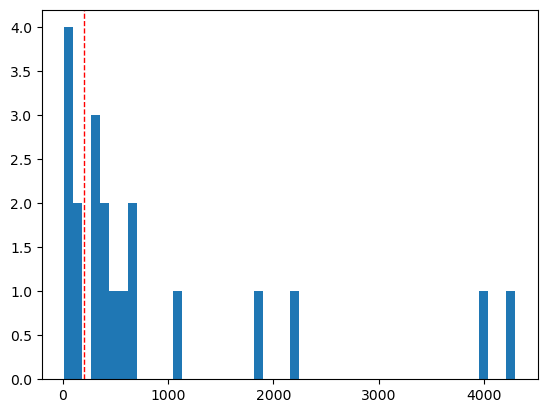

In [1039]:
# investigate very old wines
old_wines = df_wine_com[df_wine_com['vintage'] < '1985']
plt.hist(old_wines['prices'], bins=50)
plt.axvline(x=200, color='r', linestyle='dashed', linewidth=1, label='$200');

In [1040]:
'''
remove vintage for wines below $200 in price and 'older' than 1985
having investgated them individually these are wines with the established year in their name 
as opposed to the actual vintage ( year grape was picked)
'''
df_wine_com.loc[(df_wine_com['prices'] < 200) & (df_wine_com['vintage'] < '1985'), 'vintage'] = 'unknown'

In [1041]:
# drop wines with ml not equal to 750 and then drop ml column
df_wine_com = df_wine_com[df_wine_com['ml'] == 750].copy()
df_wine_com.drop(columns=['ml'], inplace=True)

In [1042]:
df_wine_com['color_wine'].value_counts()

color_wine
Red Wine                 8983
White Wine               3687
Sparkling & Champagne     959
Pink and Rosé             413
0                         199
Collectible                25
Screw Cap                  20
Boutique                    7
Green Wine                  4
Great Gift                  2
Name: count, dtype: int64

In [1043]:
def remove_accents(x):
    return unidecode(x)
df_wine_com['color_wine'] = df_wine_com['color_wine'].apply(remove_accents)

In [1044]:
def get_wine_variety(x):
    x = x.lower()
    try: 
        if 'red' in x: 
            return 'red'
        elif 'white' in x: 
            return 'white'
        elif 'ros' in x or 'pink' in x:
            return 'rose'
        elif 'sparkling'  in x or 'champagne' in x or 'prosecco' in x or 'espumante' in x:
            return 'sparkling'
        else:
            return 'other'
    except:
        return 'error parsing' 

In [1045]:
df_wine_com['wine_variety'] = df_wine_com['color_wine'].apply(get_wine_variety)

In [1046]:
# check changes
df_wine_com.drop(columns=['color_wine'], inplace=True)
df_wine_com['wine_variety'].value_counts()

wine_variety
red          8983
white        3687
sparkling     959
rose          413
other         257
Name: count, dtype: int64

In [1047]:
# remove 'other' wine varieties
df_wine_com = df_wine_com[df_wine_com['wine_variety'] != 'unknown'].copy()

In [1048]:
# rename columns 
df_wine_com.rename(columns = {'names' : 'name',
                            'prices' : 'price',
                            'ratings' : 'rating',
                            'ratingsnum': 'rating_qty', 
                            'rates' : 'reviewed_by'}, inplace = True)

In [1049]:
# remove accents from columns 
df_wine_com['name'] = df_wine_com['name'].apply(cf.uniform_strings)

In [1050]:
# extract region name from country column 
def get_region(country):
    from_index = country.lower().find('from')
    comma_index = country.find(',')
    if from_index!= -1 and comma_index!= -1:
        return country[from_index+5:comma_index]
    elif from_index!= -1:
        return country[from_index+5:]
    else:
        return 'unknown'

df_wine_com['region'] = df_wine_com['countrys'].apply(get_region)

# drop 33 wines were region was not found 
df_wine_com = df_wine_com[df_wine_com['region'] != 'unknown'].copy()


In [1051]:
# extract country name from country column 
def get_country(country):
    comma_index = country.find(',')
    if comma_index == -1:
        return 'unknown'
    else:
        return country.split(", ")[-1]
        

df_wine_com['country'] = df_wine_com['countrys'].apply(get_country)
df_wine_com['country'].value_counts()

# drop 33 wines were region was not found 
#df_wine_com = df_wine_com[df_wine_com['region'] != 'unknown'].copy()


country
France          4128
California      2845
Italy           2381
unknown         1363
Spain            926
Australia        433
Argentina        407
Washington       300
Germany          258
Oregon           241
Chile            219
Portugal         219
New Zealand      202
Other U.S.       107
South Africa      99
Austria           74
Greece            62
Canada             2
Name: count, dtype: int64

In [1052]:
# investigate the unknowns
df_wine_com[df_wine_com['country'] == 'unknown'].head()

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country
6,1000 Stories Bourbon Barrel Aged Prospectors P...,19.99,0.0,0,Cabernet Sauvignon from California,0.0,WW,2020,red,California,unknown
7,1000 Stories American Barrel Aged Pinot Noir 2020,17.99,0.0,0,Pinot Noir from California,14.5,0,2020,red,California,unknown
8,1000 Stories Bourbon Barrel Aged Zinfandel 2020,18.99,3.8,11,Zinfandel from California,15.5,WW,2020,red,California,unknown
9,1000 Stories Bourbon Barrel Aged Chardonnay 2019,19.99,4.4,10,Chardonnay from California,14.4,TP,2019,white,California,unknown
10,1000 Stories Bourbon Barrel Aged Prospectors P...,18.99,0.0,0,Cabernet Sauvignon from California,14.9,0,2018,red,California,unknown


In [1053]:
us_states = (
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
)

df_wine_com.loc[df_wine_com['region'].isin(us_states), 'country'] = 'United States'

In [1054]:
# all unknown countries are cases where no region was available 
region_problems = df_wine_com[df_wine_com['country'] == 'unknown']
region_problems['region'].value_counts()

region
Israel               115
South Africa         105
Chile                 70
Portugal              70
Spain                 69
France                60
Italy                 55
Argentina             32
Uruguay               23
Austria               23
Greece                23
Australia             20
Lebanon               11
England               10
Slovenia               9
Germany                9
Hungary                8
Croatia                6
Brazil                 5
New Zealand            3
Armenia                3
China                  2
Other                  2
Macedonia (FYROM)      2
Other U.S.             1
Name: count, dtype: int64

In [1055]:
# move those regions that are countries to the country column 
df_wine_com.loc[df_wine_com['country'] == 'unknown', 'country'] = df_wine_com.loc[df_wine_com['country'] == 'unknown', 'region']
# make those regions that are countries 'unknown'
df_wine_com.loc[df_wine_com['region'] == df_wine_com['country'], 'region'] = 'unknown'
# combine U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'Other U.S.', 'country'] = 'United States'
# combine all U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'California', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Washington', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Oregon', 'country'] = 'United States'
# rename macedonia 
df_wine_com.loc[df_wine_com['country'] == 'Macedonia (FYROM)', 'country'] = 'Macedonia'

df_wine_com['country'].value_counts()

country
France           4188
United States    4121
Italy            2436
Spain             995
Australia         453
Argentina         439
Portugal          289
Chile             289
Germany           267
New Zealand       205
South Africa      204
Israel            115
Austria            97
Greece             85
Uruguay            23
Lebanon            11
England            10
Slovenia            9
Hungary             8
Croatia             6
Brazil              5
Armenia             3
China               2
Other               2
Canada              2
Macedonia           2
Name: count, dtype: int64

In [1056]:
# Isolate grape varieties from countrys column 
def get_grape_1(x):
    from_index = x.lower().find(' from')
    return x[:from_index]
df_wine_com['grape_variety'] = df_wine_com['countrys'].apply(get_grape_1)

In [1057]:
# EXTRACT PRODUCER NAMES 
# Step 1 - Match with producers from other datasets and custom list
custom_producer_list = ['Veuve Clicquot', 'Verite', 'Altar Uco Edad Media', 
                        'Alex Gambal', 'Amapola Creek', 'Alex Foillard', 'Abbona', 
                        'Agricola De Borja Vina', 'Alain Chavy', 'Anne Pichon Sauvage', 
                        'Adamvs', 'Altos Las Hormigas ', 'Anne Amie', 'Altano', 'Alpha Omega', 
                        'Albert Boxler Edelswicker','Abreu Vineyards', 'Adriano Marco', 'Alvaro Castro Dac', 
                        'Alberto Longo', 'Ameztoi', '12 Linajes', 'Ancient Peaks', 
                        'Alessandro Gian Natale', 'Alma Negra M', '4 Kilos', 'Alphonse Mellot', 
                        'Alpha Box Dice', 'Alheit','Acinum', "1000 Stories","Fontanafredda","Fonterenza",
                        "Fonseca","Firestone","Firesteed","Gabrielskloof","Frescobaldi","Sandeman", "Samsara",
                        "Sena","Selbach","Ravines","Dugatpy", "Dows Vale", "Dows", "Sine Qua Non","Saxum","Querciabella",
                        "Gabrielskloof", "Vanderpump", "Marchandtawse","Lafargevial","Grahams","Danjeanberthoux","Cosentino", 
                        "Argentiera",   "Broadbent","Valdespino","Simonnetfebvre","Pellegrino","Ovid","Laurentperrier","Caposaldo",
                        "Broadbent", "Vivaltus","Popup Piperheidsieck","Morey-Coffinet","montirius","Marchesi","Lustau","Jansz",
                        "Guigal","e Guigal","Cockburns","Chesterkidder","Cignale","Brocard", "Timeless","Monocle","Leviathan",
                        "Gordo","Goutorbe","Futo","Episode","Croft","Cazals","caro","Calma", "Caiarossa", 
                        "Matchbook Estate","Masut Estate Vineyard","Matanzas Creek","00 Wines","Valiano","Semeli","Sclavos","Saggi",
                        "Nortico","Milenrama", "1924", "Viticcio", "Vinum Cellars", "Vivera", "Vins El Cep", "Vinos De Arganza", 
                        "Vinicola Serena Luca Paretti", "Vineyard 29", "Vincent Paris", "Vina Ventisquero", 
                        "Vina Tarapaca", "Vina Robles", "Vina Maitia", "Vina Alicia", "Vilmart Cie", 
                        "Villota", "Villa Wolf Pfalz", "Villadoria", "Villa Jolanda", "Vignoble Du Reveur", 
                        "Vigneti Vecchio", "Vigneti Massa", "Vigneti Del Sole", "Vigne Rada", 
                        "Vignai Da Duline", "Vigilance", "Vie Di Romans", "Vidalfleury", "Mollydooker", 
                        "Veuve Fourny Et Fils", "Veuve Ambal", "Verbena", "Venturini Baldini", "Vandal Gonzo", 
                        "Van Zellers", "Van Duzer", "Valravn", "Valley Vineyards", "Valley Of The Moon", 
                        "Valle Dellacate", "Val Di Toro", "Val De Mer By Patrick Piuze", "Unico Zelo", "ladoucette", 
                        "Tyler Winery", "Turnbull", "Troupis Winery", "Trig Point", "Trentadue", "Trefethen", 
                        "Toscolo Chianti", "Tornatore", "Tomaiolo Chianti", "Toad Hollow", "Tincan", "Tim Smith", 
                        "Tikal", "Tiamo", "Thistledown", "Thierry Germain", "The Winners", "The Winery Of Good Hope", 
                        "The Vice", "The Terraces", "The Hilt", "The Federalist", "The Dreaming Tree", "The Crusher", 
                        "The Chook", "The Calling", "The Boneline", "Textbook", "Teutonic", "Terrunyo", 
                        "Terroir Al Limit", "Terra Doro", "Terra Costantino", "Terlato Family Vineyards", "Terlan", 
                        "Teperberg", "Tenuta Sette", "Tenuta Santanna", "Tenuta Di Valgiano", "Tenuta Di Trinoro", 
                        "Tenuta Di Arceno", "Tenet The", "Te Pa Wines", "Taylor Fladgate", "Tatomer", "Tascante", 
                        "Tangley Oaks", "Tangent", "Talley", "Taittinger", "Tait", "Taft Street", 
                        "Tabarrini", "T Berkley", "Szigeti", "Sybille Kuntz", "Swanson", 
                        "Sur De Los Andes", "Summerland", "Suavia", "Strub Niersteiner", "Stonestreet", "Stolpman Vineyards", 
                        "Stoller", "Stewart", "Sterling", "Stephane Coquillette", "Stella Rosa", 
                        "mollydooker", "Steele", "Stave Steel", "Starborough", "Stanton Vineyards", 
                        "Standing Stone Vineyards", "Stags Leap", "Staglin", "St Supery Dollarhide", 
                        "St Innocent", "St Francis", "St Huberts", "Spy Valley", "Spring Valley", 
                        "Spring Mountain", "Source Sink", "Sonomacutrer", "Sommariva", "Somerston", 
                        "Somek Estate", "Solena Estate", "Sokol Blosser", "Snowden", "Smoking Loon", 
                        "Smith Woodhouse", "Smith Hook", "Small Vines", "Small Gully", "Skouras", 
                        "Sixto", "Six Sigma Ranch", "Sisters Run", "Simi", "Silver", "Siglo", 
                        "Sigalas", "Sierra De Tolono", "Sierra De La Demanda", "Siduri", "Shinas Estate", 
                        "Sheridan Vineyard", "Shaya", "Shaw Smith",     "Shannon Ridge", "Sextant", "Seven Hills Winery", "Sesti", "Seresin", 
                        "Serego Alighieri", "Sequoia Grove", "Sella", "Segals", "Secret Indulgence", 
                        "Secret Door", "Sebastiani North Coast", "Sean Minor", "Scribe", "Scotto Family Cellars", 
                        "Scott Harvey", "Schramsberg", "Schrader", "Schooner By Caymus", "Scholium Project", 
                        "Schlossgut Diel", "Schloss Vollrads", "Schloss Lieser", "Scharffenberger", "Schafrohlich", 
                        "Schaferfrohlich", "Scatte Peaks", "Scarpetta", "Scarecrow", "Scaia", 
                        "Savage", "Sauvion", "Sartarelli", "Santa Julia", "Santa Barbara Winery", 
                        "Sanford", "Sandrone", "Sandhi", "San Simeon", "Salvestrin", 
                        "Saintsbury", "Saints Hills", "Sager", "Sadie Family", "Sa P", 
                        "Ryme Las Brisas", "Ryan Patrick", "Rutini", "Rutherford", "Rui Roboo", 
                        "Ruggeri", "Rudi Pichler", "Routestock", "Round Pond", "Roth Estate", 
                        "Rotem Mounir", "Roscato Dolce", "Roots Run Deep", "Root 1", "Ron Rubin", 
                        "Roger Sabon", "Roger Neveu", "Rodney Strong", "Rodano", "Roco", 
                        "Roberto Voerzio", "Roberto Henriquez", "Robert Weil", "Robert Sinskey", "Robert Oatley", 
                        "Robert Foley", "Robert Craig", "Riposte", "Riofavara", "Ridge", "Ricco", "Rhys Vineyards", "Renwood", "Remoissenet", "Relax", "Reira", 
                        "Regaleali", "Recanati", "Rebholz", "Reata", "Realm Cellars", "Raymond", "Raventos", "Raricarano", 
                        "Rare Wine", "Ramon", "Ramey", "Rainer Schnaitmann", "Raen", "Radley Finch", "Racines", 
                        "R Lopez De Heia", "Qupe", "Quivira", "Quilceda Creek", "Quartz Reef", "Quady Vya", 
                        "Pursued By Bear", "Punta Crena", "Psagot", "Prost", "Principe Pallavicini", "Pride Mountain", 
                        "Powell Son", "Porter Creek", "Poppy", "Ponzi", "Pommery", "Pol Roger", "Point Ormond", 
                        "Poggio Anima", "Poderi Vaiot", "Podere Castorani", "Plungerhead Lodi", "Piperheidsieck", 
                        "Piper Sonoma", "Pinol", "Pine Ridge", "Pindar", "Pikes", "Pievalta", "Pietro Caciorgna", 
                        "Pietradolce", "Pierre Sparr", "Pierre Moncuit", "Pierre Gimonnet", "Piedrasassi", "Piattelli", 
                        "Piaggia", "Philipponnat", "Philippe Le Hardi", "Philip Togni", "Phelps Creek", "Pfeffingen", 
                        "Peyrassol", "Pewsey Vale", "Peter Paul", "Peter Michael", "Peter Dipoli", "Perus", "Pertoismoriset", 
                        "Pertinace", "Perrierjouet", "Perez Cruz", "Pepperwood Grove", "Pennerash", "Penley Estate", 
                        "Pellet Estate", "Peju Winery", "Pegaso", "Pedroncelli", "Pederzana", "Pecchenino", "Peay Vineyards", 
                        "Paxton Vineyards", "Paumanok", "Paula Kornell", "Paul Lato", "Paul K Et Fils", "Paul Cheneau", 
                        "Paul Bara", "Passopisciaro", "Pasqua", "Pascal Jolivet", "Parras Vinhos", "Parducci", 
                        "Paolo Conterno", "Panther Creek", "Palmina", "Palladio", "Pali Wine Co", "Palazzone", "Palazzo", 
                        "Pala", "Paitin", "Pahlmeyer", "Pacific Rim", "Oyster Bay", "Owen Roe", "Outpost", "Otuwhero Estates", 
                        "Oshaughnessy Howell", "Oro Bello", "One Stone Cellars", "Onehope", "Ochota Barrels", "Numanthia",  "Notorious Wines", "North By Northwest", "Nomine Renard", "No Girls", "Nino Franco", 
                        "Niner", "Nine", "Nikolaihof", "Nieto Senetiner", "Nicolasjay", "Nicolas Ulacia", 
                        "Nicolas Feuillatte", "Nickel Nickel", "Neyers", "Newton", "Newt Cellars", "Neudorf", 
                        "Natures Revenge", "My Favorite Neighbor", "Murphygoode", "Mumm", "Mullineux Family", 
                        "Mullercatoir", "Movia", "Moutard", "Mount Peak", "Mount Eden Vineyards", "Moulin De Gassac", 
                        "Mosquita Muerta", "Morlet", "Morgan", "Moorooduc Estate", "Montinore Estate", "Monticello", 
                        "Montecariano", "Monte Rio", "Montaribaldi", "Mongeardmugneret", "Monchhof", "Mommessin", 
                        "Moet Chandon", "Mocali", "Miraval", "Mirabeau", "Mionetto", "Ministry Of Vinterior", 
                        "Miner Family", "Milbrandt", "Middle Sister", "Michel Quenard", "Michel Men", "Michael Pzan", 
                        "Meyernakel", "Meurgeycroses", "Mettler Family Vineyards", "Merryvale", "Mercat", "Mer Soleil", 
                        "Menage A", "Melville", "Meadowcroft", "Mcmanis Family Vineyards",
                        "Mcguigan Wines", "Mcbride Sisters", "Maxville", "Mauritson", "Maurin", "Matthiasson", 
                        "Matthews Winery", "Matthew Fritz", "Mathilde Chapoutier De Provence", "Matchbook", 
                        "Massolino", "Masseria", "Massaya", "Mas De Gourgonnier", "Martini Rossi", "Martin Ray", 
                        "Marquis De La Tour", "Markus Huber", "Mark West", "Mark Ryan", "Maritana Vineyards", 
                        "Marietta Cellars", "Mariepierre Manciat", "Marcassin Marcassin", "Marcel Deiss", "Marc Hebrart", 
                        "Mapreco Vinho", "Manuel Acha Vino", "Mancino", "Maison Noir", "Maison Leroy", "Maison De Montille", 
                        "Maison Brotte", "Maggy Hawk", "Macrostie", "Macanita", "Mac Forbes", "Lynmar Winery", 
                        "Lve By John Legend", "Lusine", "Lunelli", "Luiano Chianti", "Lucien Albrecht", "Luc Belaire", 
                        "Lubanzi", "Louis Roederer", "Louis Martini", "Loosen Bros Dr L", "Long Meadow", "Lombardini Reggiano", 
                        "Lola Wines", "Lokoya", "Lofi Wines", "Locations By Dave", "Lobo Wines", "Llopart", 
                        "Livio Sassetti", "Liquid Farm", "Lionel Faury", "Lioco Sonoma", "Lindquist", "Ligniermichelot", 
                        "Lieb Cellars", "Levy Mcclellan", "Leon Beyer", "Leo Steen", "Lemelson", "Leeuwin Estate", "Lecole 41",
                        "Lecheneaut", "Le Vigne", "Le Rocher", "Le Potazzine", "Le Grand Courtage", "Layer Cake", 
                        "Laurenz V", "Laurent Fayolle", "Laurel Glen", "Larmandierbernier", "Larkmead", "Lapostolle", 
                        "Lanson Le", "Lange Winery", "Landmark", "Lamberti", "Lambert De Seyssel", "Lallier", 
                        "Lake Sonoma Winery", "Laherte Freres", "Lagarde", "Lagar Da Condesa", "Ladeiras Do Xil", 
                        "La Valentina", "La Serena", "La Posta", "La Playa Estate", "La Pivon", "La Marca Di San Michele", 
                        "La Lecciaia", "La Gioiosa", "La Follette", "La Crema", "La Celia", "L10 By Valentin Bianchi", 
                        "Kylie Minogue", "L Aubry Fils", "Kumeu River", "Kuleto Estate", "Kuentzbas", "Krugerrumpf", 
                        "Krugerpf", "Krug", "Koyle", "Tuck Beckstof", "Tres Sabores", "The Withers", "Koyle", 
                        "Koutsoyannopoulos", "Korbel", "Klinker Brick", "Kiryianni", "Kingston Family", "King Estate", 
                        "Kerr Cellars", "Kenwood", "Ken Wright Cellars", "Ken Forrester", "Kelby James Russell", 
                        "Keever Vineyards And Winery", "Keenan", "Keep", "Karthauserhof", "Karatta", "Kapcsandy Family", 
                        "Kamen Estate", "Kaesler", "Justin", "Juggernaut", "Joyce Vineyards", "Josh Cellars", "Joseph Swan", "Joseph Cattin", "Joseph Carr", 
                        "Jose Antonio", "Joostenberg", "John Duval", "Joel Gott", "Joao Portugal Ramos", 
                        "Jk Carriere", "Jj P Zeltinger", "Jj P Wehlener", "Jj P Graacher Himmelreich", 
                        "Jj P Bernkasteler", "Jim Barry", "Jeff Cohn Cellars", "Jeaunauxrobin", "Jeanpaul", 
                        "Jeanmaurice Raffault", "Jeanmarc Vincent", "Jeanluc Eric", "Jeanluc Colombo", 
                        "Jeanlouis Chave", "Jeanclaude Boisset", "Jeanbaptiste Adam", "Jean Pabiot", 
                        "Jean Laurent", "Jcb No", "Jax Vineyards", "Jaume Serra", "Januik Winery", 
                        "Jamieson Ranch Vineyards", "Jam Jar", "Jam Cellars", "Jacquesson", "Jacques Prieur", 
                        "Jacobs Creek", "J Vineyards", "J Lohr", "J Lassalle P", "J Christopher", "Isa And Pierre Clement", "Ironstone", 
                        "Iron Horse", "Innocent Bystander", "Ink Grade", "Infine 1939", "Inama", 
                        "Immichbatterieberg", "Illuminati", "Illahe Vineyards And Winery", "Il Poggione", "Il Palagio", 
                        "Il Molino", "Idlewild", "Hyland Estates Old Vine", "Hund Acre", "Howard Park", 
                        "Hourglass", "Horsepower Vineyards", "Hook And Ladder", "Hobo Wine", "Hobnob", 
                        "Highway 12", "High Note", "Hickinbotham", "Hexamer", "Hewitson", 
                        "Hestan Vineyards", "Hess", "Hermann J Wiemer", "Henriot", "Henri Dosnon", 
                        "Henri Champliau", "Henri Bourgeois", "Hendry", "Heitz Cellar", "Heidi Schrock", 
                        "Hearst Ranch", "Hatzidakis", "Hartford Court", "Harlan", "Hands", 
                        "Hamilton Russell", "Hamel", "Hall", "Hagafen", "Gustave Lorentz", "Gusbourne", "Gundlach Bundschu", "Gunderloch", "Guido Porro", 
                        "Gruet", "Grounded Wine Co", "Grosset", "Grgich Hills Estate", "Greg Norman Estates", 
                        "Green Chiles", "Granbazan Etiqueta", "Gran Moraine", "Gramercy Cellars", "Graham Beck", 
                        "Grace Family", "Gota Wines", "Gonzalez Byass", "Gonetmedeville", "Goldschmidt Vineyard", 
                        "Glos", "Giovanni", "Gilgal", "Gilbert", "Gianni", 
                        "Giacomo", "Ghostwriter", "Ghost", "Ghettina Franciacorta", "Georges Vernay", 
                        "Georg Breuer", "Geoffroy", "Gemstone Vineyard", "Gehricke", "Gaston Chiquet", 
                        "Gazela Vinho", "Gary Farrell", "Garciarevalo", "Garage Project", "Gamble Family Vineyards", 
                        "Gaia", "Frogs Leap", "Frias Family", "Frey", "Frei Brothers", "Freemark Abbey",
                        "Francois Roussetmartin", "Francois Pinon", "Francois Montand", "Francois Labet", 
                        "Francois Ducrot", "Francois Chidaine", "Four Vines", "Fowles Wine", "Forlorn Hope", 
                        "Forjas Del Salnes", "Forge Cellars", "Force Majeure", "Folk Machine", "Fleury Estate Winery", 
                        "Fleur De California", "Five Vintners", "Fisher Vineyards", "First Drop Mothers", "First Creek", 
                        "Fiorini", "Finca El Origen", "Finca Decero", "Finca Abril", "Filippo Grasso", "Figuiere", 
                        "Figgins", "Feudo Montoni", "Feudo Di Santa", "Fess Parker", "Faustino", 
                        "Fattoria Moretto", "Fattoria Del Cerro", "Fattoria Dianella", "Fattoria La Fiorita", "Far Niente", 
                        "Far Mountain", "Fantinel", "Fantesca", "Familia Traversa", "Familia Schroeder", 
                        "Familia Montana", "Familia Mayol", "Familia Cassone", "Fairchild", "Failla", "Eyrie",
                        "Evening Land Seven Springs", "Eva Fricke", "Etchart", "Esk Valley", "Ernest Vineyards", 
                        "Eric Texier", "Eric Chevalier", "Eppa Suprafruta", "Enroute Winery", "Empire Estate", 
                        "Emmerich Knoll", "Emmanuel Giboulot", "Emblem By Michael Mondavi", "Elouan", "Elk Cove", 
                        "Elderton", "Eisele Vineyard", "Edmunds St John", "Eden Rift", "Edaphos", 
                        "Echeverria", "E Pira", "Duvalleroy", "Duttongoldld", "Durigutti", 
                        "Dupuis", "Duo Tons De Duo", "Dunham Cellars", "Dumol", "Duemani", 
                        "Duckhorn", "Dry River Wines", "Dry Creek", "Drappier", "Dr Loosen", 
                        "Dr Konstantin", "Dr Hermann", "Dourthe La Grande", "Dora Di Paolo", "Dopff Irion", 
                        "Donnhoff", "Donnachiara", "Donati Family", "Domaine Ponsot", "Domaine Weinbach", 
                        "Domaine Thibault", "Domaine Tatsis", "Domaine Salvard", 
                        "Domaine Saint", "Domaine Roulot", "Domaine Rollin", "Domaine Rolet", "Domaine Robert", 
                        "Domaine Ponsot", "Domaine Pierre", "Domaine Pelaquie", "Domaine Paul", "Domaine Nicolas", 
                        "Domaine Parent", "Domaine Nico", "Domaine Leseurre", "Domaine Les Aphillanthes", 
                        "Domaine Laroche", "Domaine Lafond", "Domaine Jeancharles", "Domaine Jean Vullien", 
                        "Domaine Hubert", "Domaine Guillotbroux", "Domaine Goisot", "Domaine Glinavos", 
                        "Domaine Giraud", "Domaine Gerard", "Domaine Francois", "Domaine Font Du Vent", 
                        "Domaine Felettig", "Domaine Eugene Carrel Fils", "Domaine Du Pere", "Domaine Dirlercade", 
                        "Domaine De Villaine", "Domaine De Piaugier", "Domaine De Marcoux", "Domaine De Larlot",
                        "Domaine Dardhuy", "Domaine Comte", "Domaine Claude", "Domaine Chasselay", "Domaine Charles", 
                        "Domaine Chante", "Domaine Bott", "Domaine Bernard", "Doliveira", "Dog Point Vineyard", 
                        "Do Reiro", "Disznoko", "Dirupi", "Dierberg", "Dibon Cava", 
                        "Dfj Vinhos", "Deutz", "Della Vite", "Delinquente", "Delamotte", 
                        "Del Dotto", "Dehours", "Decibel Wines", "Deangelis", "De Wetshof", 
                        "Davis Family Vineyards", "Davis Bynum", "Davide Vignato", "David Franz", "David Arthur", 
                        "Davey Browne", "Dashe", "Darms Lane", "Darioush", "Daou Vineyards", 
                        "Dandelion Vineyards", "Dana Estates", "Damilano", "Cupcake Vineyards", "Cuentavinas", 
                        "Cruse Wine", "Crossbarn", "Crosby", "Crocker Starr", "Cristom", 
                        "Criss Cross", "Creek", "Crazy By Nature", "Cowboy", "Covenant", 
                        "Cousino Macul", "Courbis Cornas", "Coup De Foudre", "Cottanera Etna", "Cosse Et Maisonneuve", 
                        "Corvidae", "Correlation Wine Co", "Cooper Mountain", "Contratto", "Contino", 
                        "Conterno Fantino", "Concha Y Toro", "Concannon", "Comte Armand", "Complant", 
                        "Commanderie", "Colterenzio", "Colpetrone", "Collet", "Colene Clemens", "Colgin", "Col De Salici", "Codorniu", "Cobb Wines", 
                        "Coast Cellars", "Clover Hill", "Clos Saintjean", "Clos Sainte", "Clos Lachance", "Clos Du Val", 
                        "Clos Du Bois", "Clos Des Fous", "Clos De La Tech", "Clos Canarelli", "Clos Bellane", 
                        "Clos Amador", "Cline Ancient", "Cleto Chiarli", "Clay Shannon", "Clarendelle", "Cipresso 43", 
                        "Cigliuti", "Cic Cellars", "Christophe Mittnacht", "Chris Ringland", "Cherry Pie", 
                        "Chateau Tertre", "Chateau Tanunda Grand Barossa", "Chateau Rayas", "Chateau Hautblanville", 
                        "Chateau Fontanes", "Chateau De Rouanne", "Chateau De Plaisance", "Chateau De Lescarelle", 
                        "Chateau De La Maltroye", "Chateau De Fontenille", "Charlotte Dalton", "Charles Krug", 
                        "Charles Heidsieck", "Charles Ellner", "Charles De E", "Charles De Cazanove", "Chapter 24", 
                        "Chappellet", "Chapel Hill", "Chan De Rosas", "Champalou Vouvray", "Champagne Telmont", 
                        "Champagne Ployezjacquemart", "Champagne Palmer", "Champagne Mouzonleroux", 
                        "Champagne Legras Haas", "Champagne Leclerc Briant", "Champagne Le Mesnil De S Grand Cru", 
                        "Champagne Jl Vergnon", "Champagne Henri Giraud", "Champagne Doyard", "Champagne Bernard Remy", 
                        "Champagne Barons De Rothschild", "Champagne Agrapart Fils", "Chamisal Vineyards", "Cesconi", "Certosa Di Belriguardo", 
                        "Cerbaiona", "Caymus Suisun", "Caves Sao Joao", "Caves Roger Goulart", "Cave De Ribeauville", 
                        "Cavallotto", "Catherine Pierre", "Cataldi Madonna", "Castoro Cellars", "Castle Rock", 
                        "Castello Di Volpaia", "Castello Di Querceto", "Castello Di Neive", "Castello Di Meleto", 
                        "Castello Di Luzzano", "Castello Di Bossi", "Castagnoli Chianti", "Case Paolin", 
                        "Casanuova Delle", "Casa Smith", "Carpineto Chianti", "Carol Shelton", "Carneros", 
                        "Carmel Road", "Cardedu", "Cantine Maschio", "Cantine Lunae", "Cantine Elvio", 
                        "Cantine Cavicchioli", "Candoni", "Can Verdura", "Campriano Chianti", "Cambria", 
                        "Cakebread", "Cafe De Paris", "Ca Momi", "Ca Furlan", "Burklinwolf", "Bucklin Old Hill Ranch", 
                        "Bryn Mawr Vineyards",  "Brundlmayer", "Bruna Grimaldi", "Browne Family Vineyards", "Brown Estate", "Brotherhood", 
                        "Broadside", "Brittan", "Breathless", "Bread Butter", "Branson Coach House Coach House", 
                        "Brancott", "Boyermartenot", "Bouvet", "Boundary Breaks", "Bouchard", 
                        "Bouchaine", "Botromagno", "Botanica Wines", "Borgo Conventi", "Bonny Doon", 
                        "Bollinger", "Bodini", "Bodegas Virgen Del Galir", "Bodegas Vatan Nisia", "Bodegas Ugalde", 
                        "Bodegas Santalba", "Bodegas Renacer", "Bodegas Ramirez", "Bodegas Poniente", "Bodegas Nando Rez De Ganuza", 
                        "Bodega Pablo Fallabrino", "Bodega Noemia De Patagonia", "Bodega Monteviejo", "Bodega Malma", 
                        "Bodega Aniello", "Blue Rock", "Blandys 5", "Blackbird Vineyards", "Black Sheep", 
                        "Black Estate", "Bindi Wines", "Billecartsalmon",  "Bilahaut By Michel", "Big Smooth", "Big Basin", "Bieler Pere", "Bevan Cellars", 
                        "Bethel Heights", "Bests Great Western", "Besserat De Fon", "Berton Vineyards Metal Label", "Berlucchi", 
                        "Benziger", "Benovia Russian River", "Benjamin Romeo", "Bench Sonoma", "Bellissima", 
                        "Bellafina", "Bella Grace", "Beeslaar", "Bedrock Wine", "Beckmen", 
                        "Becklyn", "Beaux Freres", "Beaumont", "Beaulieu Vineyard", "Beau Joie", 
                        "Bastianich", "Bassermannjordan", "Barton Guestier", "Bartenura", "Barone Pizzini", 
                        "Barnard Griffin", "Barkan", "Baricci Colombaio", "Barboursville", "Banshee Sonoma", 
                        "Balletto Winery", "Baillylapierre", "Badia A Coltibuono", "Bacio Divino", "Azienda Agricola", 
                        "Azelia", "Ayres", "Avinyo", "Avaline", "Austin", 
                        "Au Contraire", "Au Bon Climat", "Astrolabe", "Ashes & Diamonds",  "Artesa", "Arrowood", "Arnot", "Arnaldo Caprai", "Armand De Brignac", "Arista Winery", "Arietta", 
                        "Argyros", "Argyle", "Aresti", "Archery Summit", "Ar Pe", "Ar Lenoble", "Anwilka", "Antucura", 
                        "Antica", "Anthony Road", "Anthill Farms", "Annabella", "Animo By Michael Mondavi", "Angels & Cowboys", 
                        "Angeline", "Anakota Helena", "Amici", "Alvaro", "Altar Uco", "Alpha Estate", "Alma Rosa", 
                        "Alkoomi", "Alfo Bertolani", "Alexander", "Alexana Terroir", "Albert Boxler", "Alberico", "Alban", 
                        "Aj Adam D", "Agusti Torello", "Agua De Piedra", "Agricola De Borja", "Adobe Road", "Adelsheim", 
                        "Adelina Wines", "Accendo Cellars", "Abbona", "Abbazia Di Novacella", "A Tribute To Grace", "A To Z", 
                        "1849", "7 Deadly",     "Agricola De Borja", "Albert Boxler", "Alfo Bertolani", "Alma Negra", "Alta Luna", 
                        "Altar Uco", "Ampelos Cellars", "Arnot", "Annabella", "Antinori", 
                        "Apaltagua", "Apothic", "Aquinas", "Argiano", "Argento", 
                        "Argentiera", "Argiolas", "Argyle", "Argyros", "Arietta", 
                        "Arnotroberts", "Arrowood", "Artadi", "Artesa", "Artuke", 
                        "Arzuaga", "Astrolabe", "Atalaya", "Auspicion", "Avaline", 
                        "Avalon", "Avignonesi", "Avinyo", "Abbotts Delaunay", "Vina Alarde", 
                        "Marques De Murrieta", "Definition", "Bodegas Hidalgo Triana",
                        "Ammazza", "Jackson Estate", "Vina Vik", "V8", "Tuck Beckstof",
                        "Terroir Al Limit", "Terora Di Paolo", "Tenshen", "Tenet",
                        "Tania Et Vincent", "Tamber Bey", 
                        "Scatte Peaks", "Salvatore Molettieri", "Rutherford",
                        "Rui Roboo Madeira", "Ruca Malen", "Round Pond", "Roscato Dolce",
                        "Rombauer", "Robert Mondavi", "Rivetto", "Ferreira", "Raricarano",
                        "R Lopez De Heia", "Quinta Do Noval", "Quinta De La Rosa",
                        "Quinta De Chocapalha", "Quinta Da Pellada", "Prayers Of Sinners",
                        "Paul K Et Fils", "Ostertag", "Once Future", "Murgo", "Montsarra",
                        "Monte Bernardi", "Meyerfonne", "Mathilde Chapoutier De Provence",
                        "Markham", "Marcassin", "Malacara", "Maison Lenvoye", "Macari",
                        "Luca", "Lofi", "Lisini", "Lini 910", "Lecole", "Le Cadeau Vineyard",
                        "Lavau", "Kinsella Estates", "Joseph Phelps", "Jonata", "Jermann",
                        "Isa And Pierre Clement", "Inglenook", "Hund Acre", "Hosmer Winery",
                        "Heritage School Vineyards", "Heritance", "Heinz Eifel", "Hamilton Russell",
                        "Gualdo Del Re", "Grossot", "Green Chiles", "Gran Sasso",
                        "Giuliano Rosati", "Ghettina Franciacorta", "Fritz Haag",
                        "Francoise Savignylesbeaune", "Enrique Foster", "Duttongoldld",
                        "Duo Tons De Duo", "Dr Paulybergweiler", "Dr Stephens Estate",
                        "Douloufakis", "Domaine Zafeirakis", "Davies", "Dalla Valle",
                        "Cuvaison", "Cune", "Clos Henri", "Cic Cellars",
                        "Chateau Maupague De Provence", "Charles De E", "Chandon",
                        "Champagne Le Mesnil De S Grand Cru", "Canardduchene", "Brendel",
                        "Bodegas Nando Rez De Ganuza", "Besserat De Fon", "Berthetbondet Du Jura",
                        "Bergstrom", "Benito Santos", "Azienda Agricola", "Alfo Bertolani",
                        "Albert Boxler", "Aj Adam", "Agricola De Borja", "4 Kilos", 
                        'domaine de la romanée-conti',
                        "Valdo", "Ulysse Collin", "Twenty Bench", "Tropical", "Tilia",
                        "Terroir Al Limit", "Tenet",  "Syltbar",
                        "Sun Goddess By Mary J Blige", "Stags Leap", "Rui", "Ruinart",
                        "Roscato Dolce", "Round Pond", "Rombauer", "Riondo",
                        "Revolution Wine Company", "Tuck Beckstof", "Tenuta Anfosso",
                        "St Supery", "Scatte Peaks", "San Polino", 'Tamarack Cellars', 'Tablas Creek',
                        "Antinori", "Nicolas Reau", "Mount Mary", "Michel Men", "Michael Pzan",
                        "Mathilde Chapoutier", "Mas Champart", "Luna Nuda", "Louis Jadot",
                        "Domaine Des Heritiers Louis Jadot", "La Playa", "Le Roi Des Pierres",
                        "Le Colture", "Le Charmel", "Lang Reed", "La Poderina", "La Marca",
                        "Jeannoel Gagnard", "J Lassalle", "Isa And Pierre Clement", "Il Borro",
                        "Hund Acre", "Hamilton Russell", "Green Chiles", "Gran Passione",
                        "Ghettina Franciacorta", "Fitvine Wine", "Duo Tons De Duo", "Domaine Humbert",
                        "Da Vinci", "Clos Dalian", "Cliff Lede", "Cic Cellars", "Chateau Gazin",
                        "Chateau Bourgneuf", "Chateau Belair", "Chateau Beauchene", "Cedar Salmon",
                        "Casa Vinicola Botter", "Carlo Giacosa", "Brick Mortar", "Booker Vineyard",
                        "Bodegas Nando Rez De Ganuza", "Bisol Jeio", "Barossa Valley", "B Kosuge",
                        "Azienda Agricola", "Alma Negra", "Altar Uco", "Albert Boxler", "4 Kilos",
                        "Domaine De La Bergerie", "Stephane Aviron", "Nicole Chanrion",
                        "Lorgeril Domaine De La Borie Blanche", "Henry Marionnet Domaine De La Charmoise",
                        "Domaine de la Charmoise Touraine", "Domaine De La Vougeraie Vougeot",
                        "Domaine De La Vougeraie Terres", "Domaine De La Vieille Julienne Chateauneufdupape",
                        "Domaine De La Taille Aux Loups", "Domaine De La Romaneeconti",
                        "Domaine De La Prebende", "Domaine De La Pousse Dor", "Domaine De La Pirolette",
                        "Domaine De La Pauline", "Domaine De La Pepiere", "Domaine De La Mordoree",
                        "Domaine De La Guilloterie", "Domaine De La Grandcour Fleurie",
                        "Domaine De La Fruitiere", "Domaine De La Damase",
                        "Domaine De La Charbonniere Chateauneufdupape", "Domaine De La Chanteleuserie Bourgueil",
                        "Domaine De La Chanade", "Domaine De La Cadette Bourgogne",
                        "Domaine De La Cadette", "Domaine De La Bongran Vireclesse",
                        "Domaine De La Bergerie", "Chateau Fuisse Julienas"

]

                        

all_producers = list(df_viv_1['winery'].unique()) + list(df_viv_2['winery'].unique()) + custom_producer_list
all_producers  = [cf.uniform_strings(word) for word in all_producers]
all_producers.remove('Domaine De La')

In [1058]:
df_wine_com['name'] = df_wine_com['name'].apply(cf.uniform_strings)

In [1059]:
# 70% of producers matched by finding producer names from other datasets within 'name'
# X producers matched 4576 remaining (total 14266)
def extract_string(input_str, string_list):
    input_str_list = input_str.split()
    for string in string_list:
        if string == input_str_list[-1]:
            return string.strip()
        else:
            string = string + ' ' 
            if string in input_str:
                return string.strip()
    return 'review'

In [1060]:
df_wine_com['producer_clean'] = df_wine_com['name'].apply(lambda x: extract_string(x, all_producers))

In [1061]:
# test = 'Wine De LA Abbona'
# test1 = "Wine De LA Annabella"
# test2 = '1849 wine wine'
# test3 = 'Aj Adam D Hofberg'
# test4 = 'Ydooker Gigglepot'
# test5 = 'Mollydooker Blue Eyed Boy Shiraz 2020'
# test6 = 'Reira Dona Antonia 10 Year Tawny Port'
# test7 = 'Tamarack Cellars Firehouse Red 2019'
# test8 = 'Domaine De La Charbonniere Chateauneufdupape Mourre Des Perdrix 2016'
# extract_string(test8, all_producers)

In [1062]:
# (4576, 13)
check_wine = df_wine_com[df_wine_com['producer_clean'] == 'review']
check_wine.shape

(4171, 13)

In [1063]:
check_wine = df_wine_com[df_wine_com['producer_clean'] == 'review']
check_wine.head()

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer_clean
3,100 Nails Ranch Pinot Noir 2019,16.99,0.0,0,"Pinot Noir from Central Coast, California",14.2,WW,2019,red,Central Coast,United States,Pinot Noir,review
4,100 Nails Ranch Chardonnay 2019,16.99,0.0,0,"Chardonnay from Sonoma County, California",14.2,0,2019,white,Sonoma County,United States,Chardonnay,review
5,100 Nails Ranch Cabernet Sauvignon 2018,19.99,3.3,9,"Cabernet Sauvignon from Paso Robles, Central C...",14.2,TP,2018,red,Paso Robles,United States,Cabernet Sauvignon,review
14,12C Wines Beckstoffer Vineyard Georges Iii Cab...,119.97,0.0,0,"Cabernet Sauvignon from Napa Valley, California",0.0,0,2015,red,Napa Valley,United States,Cabernet Sauvignon,review
15,12C Wines Beckstoffer Vineyard Georges Iii Cab...,119.97,0.0,0,"Cabernet Sauvignon from Napa Valley, California",0.0,0,2014,red,Napa Valley,United States,Cabernet Sauvignon,review


In [1064]:
# STEP 2 - Isolate part before grape names, import list of grape varieties - 
# This removes grape and year from X leaving X for review. X producers remain that have not be captured by first 2 steps. 
grape_list_long = pd.read_csv('../data/grape_varieties.csv')
grape_list_long.drop(columns = ['Unnamed: 0'], inplace = True)

In [1065]:
# # worthwhile adding in any specialty varietals appearing in your dataset that aren't listed here
# def remove_varietal1(x, varietals):
#     '''
#     Removes varietal name it finds + year (4 digits) returns cleaned and capitalized producer name
#     '''
#     x = uniform_strings(x).strip().lower()
#     varietals_to_extract = [varietal for varietal in varietals if varietal in x] # consider reviewing this with example don and chardonnay
#     for varietal in varietals_to_extract:
#         if re.search(varietal, x) != None:
#             return ' '.join([i.title() for i in re.sub(varietal+'\s\d{4}', '', x).split()]).strip() 
#         else:
#             return 'review'


In [1066]:
def remove_varietal(x, varietals):
    '''
    Removes varietal name it finds + year (4 digits) and returns cleaned and capitalised producer name.
    Returns 'review' if no varietal is found.
    '''
    original_x = x  # Store original input for comparison
    x = cf.uniform_strings(x).strip().lower()
    varietals_to_extract = [varietal for varietal in varietals if varietal in x]
    #print(f"All initial varietals: {varietals_to_extract}") 
    count = 0
    for i in range(0, len(varietals_to_extract)):
        for varietal in varietals_to_extract:
            # if year still in the string
                    # if <grape><string><year>
            if re.search(rf'{varietal}\s\w*\s\d{{4}}', x)!= None:
                #print(f"X before resub {count} is: {x}") 
                x = re.sub(rf'{varietal}\s\w*\s\d{{4}}\w*','', x)
                count += 1
                #print(f"String after {count} re subs is: {x}")

            elif re.search(rf'\d{{4}}', x) != None:
                # replace varietal names and years
                #print(f"X before resub {count} is: {x}") 
                x = re.sub(rf'{varietal}\s\d{{4}}\w*', '', x)
                count += 1
                #print(f"String after {count} re subs is: {x}")
            
            else: # replace varietal name only 
                #print(f"X before resub {count} is: {x}") 
                x = re.sub(rf'{varietal}', '', x)
                count += 1
                #print(f"String after {count} re subs is: {x}")
        
    if x == cf.uniform_strings(original_x).strip().lower() or len(varietals_to_extract) == 0:
        # if no changes were made to x
        return 'review' 
    else:
        # return cleaned and capitalised producer name
        return ' '.join(word.title() for word in x.split()).strip()

In [1067]:
varietal_set_long = set(grape_list_long['Variety'].dropna().apply(lambda x: cf.uniform_strings(x).strip().lower()))

In [1068]:
# test = 'Chardonnay Vinny  oz Mc Vinard Malbec  2002'
# test1 = 'Vinny Mc Vinard Malbec Chardonnay Cats 2002'
# test2 = 'Vinny Mc Vinard don Don 2002'
# test3 = 'Vinny Mc Vinard Pinot Noir 2002'
# test4 = 'Chardon Don Vineyard Chardonnay 2020'
# test5 = 'Aj Adam Hofberg Reserve Riesling Trocken 2019' # ISSUE HERE WITH {GRAPE}{OTHER-STRING}{YEAR}
# test6 = 'Aj Adam Hofberg Reserve Riesling 2020'

# remove_varietal(test6, varietal_set_long)

In [1069]:
df_wine_com['producer_varietal_removed'] = df_wine_com['name'].apply(lambda x : remove_varietal(x, varietal_set_long))

In [1070]:
df_wine_com[(df_wine_com['producer_varietal_removed'] == 'review')]

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer_clean,producer_varietal_removed
13,12 Linajes Crianza 2014,31.99,3.9,17,"Tempranillo from Ribera del Duero, Spain",14.5,WE,2014,red,Ribera del Duero,Spain,Tempranillo,12 Linajes,review
35,19 Crimes The Warden 2018,20.99,3.7,12,"Syrah/Shiraz from South East Australia, Australia",0.0,0,2018,red,South East Australia,Australia,Syrah/Shiraz,19 Crimes,review
36,19 Crimes Hard Chard 2021,20.99,3.0,13,Chardonnay from Australia,14.0,0,2021,white,unknown,Australia,Chardonnay,19 Crimes,review
37,19 Crimes Marthas Chard 2020,13.99,3.8,24,Chardonnay from California,13.8,0,2020,white,California,United States,Chardonnay,19 Crimes,review
38,19 Crimes The Uprising 2020,11.99,4.1,41,Other Red Blends from Australia,0.0,0,2020,red,unknown,Australia,Other Red Blends,19 Crimes,review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15242,Viticcio Chianti Classico 2018,21.99,0.0,0,"Sangiovese from Chianti Classico, Chianti, Tus...",14.0,0,2018,red,Chianti Classico,Italy,Sangiovese,Viticcio,review
15244,Vivaltus 2016,99.99,0.0,0,"Tempranillo from Ribera del Duero, Spain",0.0,"D, RP",2016,red,Ribera del Duero,Spain,Tempranillo,Vivaltus,review
15246,Vivaltus La Fleur Vivaltus 2016,46.99,0.0,0,"Tempranillo from Ribera del Duero, Spain",14.5,RP,2016,red,Ribera del Duero,Spain,Tempranillo,Vivaltus,review
15247,Vivanco Rioja Blanco 2019,14.99,3.8,6,"Other White Blends from Rioja, Spain",13.0,0,2019,white,Rioja,Spain,Other White Blends,Vivanco,review


In [1071]:
df_wine_com.loc[df_wine_com['abv'] == 0, 'abv'] = np.nan

In [1072]:
#2081 producers remain that have not be captured by first 2 steps. 
df_wine_com[(df_wine_com['producer_varietal_removed'] == 'review') & (df_wine_com['producer_clean'] == 'review')].shape

(1956, 14)

In [1073]:
# def remove_grape_1(x):
#     x = str(x)
#     for item in grape_list_long['Variety']:
#         if str(item).lower() in x.lower():
#             output = x.split(item)[0].strip()
#             if output != '':
#                 return output
#     else:
#         return 'review'

In [1074]:
# test = 'Vinny Mc Vinard Pinot Noir 2002'
# print(remove_grape_1(test))

In [1075]:
# df_wine_com['producer_degraped'] = df_wine_com['name'].apply(remove_grape_1)

In [1076]:
# # STEP 3 - Make Custom Producer List cycling through names

# def match_producer(row, all_names):
#     # remove from wine names
#     no_year_name = re.sub(r'\b\d{4}\b', '', row).strip()
    
#     # split name into words 
#     words = no_year_name.split()
    
#     # Define a helper function to check for matches
#     def check_match(n):
#         prefix = ' '.join(words[:n])
#         return any(name.startswith(prefix) and name != no_year_name for name in all_names)
    
#     # Cycle through the conditions
#     if check_match(1):
#         if check_match(2):
#             if check_match(3):
#                 if check_match(4):
#                     return ' '.join(words[:4])  # if four-word match is found return the first four words 
#                 else:
#                     return ' '.join(words[:3])  # else return the first three words
#             else:
#                 return ' '.join(words[:2])  # if three-word match not found return the first two words
#         else:
#             return''.join(words[:1])  # if two-word match not found return the first word
#     else:
#         return 'review'  # if not even 2 word mathc found return 'review' if no brand name found


# # all_names is a list of all wine names without years for efficiency in lookups
# all_names = df_wine_com['name'].apply(lambda x: re.sub(r'\b\d{4}\b', '', x).strip()).tolist()

# customer_producer_list = df_wine_com['name'].apply(lambda x: match_producer(x, all_names))

In [1077]:
# customer_producer_list_distinct = customer_producer_list.unique()

In [1078]:
# for i in customer_producer_list_distinct:
#     print(i)

In [1079]:
# def verify_grape(row):
#    if row['name'].find(f"{row['grape_variety']}")!= -1:
#        output = row['name'].split(f"{row['grape_variety']}")[0].strip()
#        return output
#    else: 
#       return row['name']
    
# df_wine_com['producer_varietal_removed_verify'] = df_wine_com.apply(verify_grape, axis = 1)

In [1080]:
# df_wine_com['degrape_verified'] = df_wine_com['producer_varietal_removed_verify'] == df_wine_com['producer_varietal_removed']

In [1081]:
# total = 0
# for i in df_wine_com['producer_varietal_removed']: 
#     total += len(i)
# total/len(df_wine_com['producer_varietal_removed'])

In [1082]:
#def extract_producer(row):
#    if row['name'].find(f"{row['grape_variety']}")!= -1:
#        output = row['name'].split(f"{row['grape_variety']}")[0].strip()
#    else: 

#    return output

def get_dirty_producer(x):
    prepositions = ['of', 'de', 'la', 'di', 'qua', 'du', 'non', 'do', 'des', 'a', 'the', 'et', 'and', 'le', 
                    'del', 'dei', 'les', 'jean', 'al', 'da', 'dos', 'il', 'by', 'el', '&', 'i', 'el', 'de', 'y']
    x_words = x.split(' ')
    if x_words[1].lower() in prepositions:
        if x_words[2].lower() in prepositions:
            if x_words[3].lower() in prepositions:
                producer = x_words[0] + ' ' + x_words[1] + ' ' + x_words[2] + ' ' + x_words[3] + ' ' + x_words[4]
                return producer
            else:
                producer = x_words[0] + ' ' + x_words[1] + ' ' + x_words[2] + ' ' + x_words[3]
            return producer
        else:
            producer = x_words[0] +' ' + x_words[1] +' ' + x_words[2]
            return producer
    else:
        producer = x_words[0] + ' ' + x_words[1]
        return producer

In [1083]:
# testt = 'Vino do le Vinyard'
# get_dirty_producer(testt)

In [1084]:
df_wine_com['producer_dirty'] = df_wine_com['name'].apply(get_dirty_producer)

In [1085]:
for i in np.sort(df_wine_com['producer_dirty'].unique()):
    print(i)

00 Wines
100 Nails
1000 Stories
12 Linajes
12C Wines
13 Celsius
14 Hands
1849 Anonymous
1849 Declaration
1849 Iris
1849 Triumph
19 Crimes
1924 Double
1924 Port
1924 Sauvignon
1924 Scotch
3 Rings
4 Kilos
7 Deadly
7 Moons
7Cellars The Farm
A By Acacia
A Christmann
A Coroa
A Mano
A Margaine
A Portela
A To
A Tribute
Aalto 2019
Aalto Ps
Abacela Albarino
Abadia Retuerta
Abbadia Ardenga
Abbazia Di Novacella
Abbona Barolo
Abbona Papa
Abbona Rinaldi
Abbott Claim
Abreu Vineyards
Acacia Carneros
Accendo Cellars
Achavalferrer Finca
Achavalferrer Mendoza
Achavalferrer Quimera
Acinum Extra
Acinum Soave
Acinum Valpolicella
Acrobat Pinot
Acumen Peak
Adami Bosco
Adami Garbel
Adamvs Quintvs
Adamvs Teres
Adaptation By Odette
Addax Cabernet
Addendum Napa
Adelina Wines
Adelsheim Pinot
Adelsheim Staking
Adelsheim Willamette
Adeptos Reserve
Adobe Road
Adriano Marco
Aeris Bianco
Aeris Rosso
Agricola De Borja
Agricola Punica
Agua De Piedra
Agusti Torello
Aia Vecchia
Aichenberg Premium
Aix Rose
Aj Adam
Alain Br

In [1086]:
# (6405,)
df_wine_com['producer_dirty'].unique().shape

(6405,)

In [1087]:
shorterned_df = df_wine_com[(df_wine_com['producer_clean'] == 'review') &(df_wine_com['producer_varietal_removed'] == 'review')]

In [1088]:
all_remaining_producers =  shorterned_df['producer_dirty'].value_counts().index
all_remaining_producers = all_remaining_producers.sort_values()

In [1089]:
# find what outputed: Tenuta Di Arceno Chianti Classico

In [1090]:
def combine_methods(df):
    if df['producer_clean'] != 'review':
        return df['producer_clean']
    elif df['producer_varietal_removed']!= 'review' and df['producer_varietal_removed']!= '':
        return df['producer_varietal_removed']
    else:
        return df['producer_dirty']

df_wine_com['combined_methods_producer'] = df_wine_com.apply(combine_methods, axis = 1)

In [1091]:
df_wine_com['combined_methods_producer'].value_counts().head(50)

combined_methods_producer
Louis Latour                  80
Sine Qua Non                  57
Ridge                         49
Chanson                       35
Guigal                        33
Louis Jadot                   33
M Chapoutier                  30
Albert Bichot                 27
Rocca                         26
Selbach                       25
Chateau Ste Michelle          25
Joseph Drouhin                24
Catena                        24
Schrader                      24
Dr Loosen                     23
Bouchard Pere Fils            23
Francis Ford Coppola          23
Albert Boxler                 23
Faiveley                      23
Chateau Mouton Rothschild     20
Domaine De La Janasse         20
Gerard Bertrand               20
Billaudsimon Chablis          20
Domaine Bruno                 20
Amici                         19
Penfolds                      19
Valley Vineyards              19
Creek                         19
Delas                         19
Vietti           

In [1092]:
df_wine_com['producer'] = df_wine_com['combined_methods_producer']

In [1093]:
# investgate wine of price 9999.99 - this is a collectable highly prized wine producer Chateau Petrus
df_wine_com[df_wine_com['price'] == 9999.99]

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer_clean,producer_varietal_removed,producer_dirty,combined_methods_producer,producer
3810,Chateau Petrus 2016,9999.99,4.7,11,"Bordeaux Red Blends from Pomerol, Bordeaux, Fr...",14.5,"JS, RP, D, JD, WE, WS",2016,red,Pomerol,France,Bordeaux Red Blends,Petrus,review,Chateau Petrus,Petrus,Petrus


In [1094]:
# convert price to GBP £ using https://www.xe.com/currencytables/ at date of scrape
df_wine_com['price'] = round(df_wine_com['price'] * 0.8214659183132513,)

In [1095]:
df_wine_com['from_vivino'] = False

In [1096]:
df_wine_com.columns

Index(['name', 'price', 'rating', 'rating_qty', 'countrys', 'abv',
       'reviewed_by', 'vintage', 'wine_variety', 'region', 'country',
       'grape_variety', 'producer_clean', 'producer_varietal_removed',
       'producer_dirty', 'combined_methods_producer', 'producer',
       'from_vivino'],
      dtype='object')

In [1097]:
df_wine_com.drop(columns=['producer_clean', 'producer_varietal_removed',
                            'producer_dirty', 'combined_methods_producer' ], inplace=True)

# Cleaning Vivino 1 Dataset

In [1098]:
df_viv_1.shape

(34664, 9)

In [1099]:
df_viv_1.drop_duplicates(inplace=True)

In [1100]:
df_viv_1.head()

,name,country,region,winery,rating,numberofratings,price,year,category
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,red
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,red
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,red
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,red
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,red


In [1101]:
df_viv_1.rename(columns = {'winery' : 'producer', 
                           'numberofratings' : 'rating_qty', 
                           'category' : 'wine_variety',
                           'year' : 'vintage'
                           }, inplace = True)

In [1102]:
# remove accents from columns 
df_viv_1['name'] = df_viv_1['name'].apply(cf.uniform_strings)
df_viv_1['producer'] = df_viv_1['producer'].apply(cf.uniform_strings)
df_viv_1['region'] = df_viv_1['region'].apply(cf.uniform_strings)
df_viv_1['country'] = df_viv_1['country'].apply(cf.uniform_strings)

In [1103]:
df_viv_1.dtypes

name             object
country          object
region           object
producer         object
rating          float64
rating_qty        int64
price           float64
vintage          object
wine_variety     object
dtype: object

In [1104]:
# make name formatting structure the same as wine_com dataframe
df_viv_1['name'] = df_viv_1['producer'] + ' ' + df_viv_1['name']

In [1105]:
df_viv_1['region'].value_counts()

region
Rioja                               1300
Toscana                              996
Stellenbosch                         928
Saintemilion Grand Cru               828
Barolo                               700
                                    ... 
Sachsen                                4
Coteaux Varois En Provence             4
Orvietano Rosso                        4
Mercurey 1Er Cru Le Clos Leveque       4
Mount Veeder                           4
Name: count, Length: 624, dtype: int64

In [1106]:
df_viv_1['country'].value_counts()

country
Italy            10600
France            9024
Spain             4568
South Africa      2000
United States     1496
Chile             1304
Germany            992
Australia          984
Argentina          984
Portugal           920
Austria            880
New Zealand        252
Brazil             160
Romania             92
Lebanon             60
Israel              52
Greece              52
Switzerland         48
Hungary             36
Moldova             32
Slovenia            32
Turkey              24
Georgia             20
Uruguay             16
Croatia              8
Bulgaria             8
Canada               8
Mexico               4
China                4
Slovakia             4
Name: count, dtype: int64

In [1107]:
df_viv_1['vintage'].value_counts()

vintage
2016    7104
2017    6232
2015    5584
2018    4396
2014    3192
2013    2256
2012    1484
2011    1112
2010     696
2005     616
2019     464
2009     336
2008     320
2006     176
2007     172
2004     108
2000      76
1999      60
2001      48
2003      44
N.V.      32
1997      28
2002      28
1998      24
1996      20
1995      16
1992      12
1990       8
1989       8
1993       4
1988       4
1991       4
Name: count, dtype: int64

In [1108]:
df_viv_1.loc[df_viv_1['vintage'] == 'N.V.', 'vintage'] = 'unknown'

In [1109]:
df_viv_1['rating'].describe()

count    34664.000000
mean         3.890342
std          0.308534
min          2.500000
25%          3.700000
50%          3.900000
75%          4.100000
max          4.800000
Name: rating, dtype: float64

In [1110]:
df_viv_1['rating_qty'].describe()

count    34664.000000
mean       415.287445
std        899.687438
min         25.000000
25%         66.000000
50%        157.000000
75%        401.000000
max      20293.000000
Name: rating_qty, dtype: float64

In [1111]:
df_viv_1['price'].describe()

count    34664.000000
mean        39.145065
std         84.932632
min          3.550000
25%         10.680000
50%         18.200000
75%         38.160000
max       3410.790000
Name: price, dtype: float64

In [1112]:
# convert price to GBP £ from € using https://www.xe.com/currencytables/ at date of scrape
df_viv_1['price'] = round(df_viv_1['price'] * 0.8371915735092197,2)

In [1113]:
# make empty abv column 
df_viv_1['abv'] = np.nan

In [1114]:
df_viv_1['reviewed_by'] = 'unknown'

In [1115]:
df_viv_1['from_vivino'] = True

In [1116]:
df_viv_1.head()

,name,country,region,producer,rating,rating_qty,price,vintage,wine_variety,abv,reviewed_by,from_vivino
0,Chateau La Providence Pomerol 2011,France,Pomerol,Chateau La Providence,4.2,100,79.53,2011,red,NaN,unknown,True
1,Chateau Montredon Lirac 2017,France,Lirac,Chateau Montredon,4.3,100,12.98,2017,red,NaN,unknown,True
2,Renzo Masi Erta E China Rosso Di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,6.24,2015,red,NaN,unknown,True
3,Cavalchina Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,7.30,2019,red,NaN,unknown,True
4,Markowitsch Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,24.40,2016,red,NaN,unknown,True


In [1117]:
# get grape variety - iteratively added grape varieties to find those missed
grape_varieties =(list(df_wine_com['grape_variety'].unique()) + ['red blend', 'shiraz', 'Pomerol', 'Lirac', 'Rosso di Toscana', 
                                                                 'Bardolino', 'Gigondas', 'Chianti', 'Monastrell', 'Sancerre Rouge',
                                                                 'Saint-Joseph', 'Fronsac','Roma Rosso','Garnacha','Barolo',
                                                                 'Côte-Rôtie','Madiran','Ruché','Tempranillo','Margaux', 'syrah', 
                                                                 'blend', 'Rioja', 'Super Tuscan', 'Chianti', 'pinot nero',
                                                                 'Carménère', 'Mencía', 'Mourvèdre', "Blaufränkisch", "Corvina",
                                                                 "Rondinella", "Molinara", "Sangiovese", 'baga', 
                                                                 "Corvina", "Rondinella", "Molinara", "Trincadeira",  "Prieto Picudo"])
def extract_varietal(input_str, varietal_list):
    varietal_list_lower = [i.lower() for i in varietal_list]
    output = ''
    matched_varietal =  [item for item in varietal_list_lower if item in input_str.lower()]
    for grape in matched_varietal:
        output += grape.strip() + ' '
        return cf.uniform_strings(output.strip())
    return 'unknown'
df_viv_1['grape_variety'] = df_viv_1['name'].apply(lambda x: extract_varietal(x, grape_varieties))

In [1118]:
# review 20440
df_viv_1['grape_variety'].value_counts().head(50)

grape_variety
unknown               19032
Cabernet Sauvignon     2224
Merlot                 1100
Pinot Noir             1044
Chianti                 912
Shiraz                  764
Barolo                  696
Malbec                  648
Rioja                   596
Pomerol                 580
Syrah                   580
Tempranillo             504
Primitivo               492
Barbera                 480
Margaux                 440
Montepulciano           428
Pinotage                320
Carmenere               244
Zinfandel               236
Garnacha                216
Zweigelt                204
Blaufrankisch           196
Red Blend               184
Gigondas                176
Grenache                164
Negroamaro              164
Lagrein                 156
Nebbiolo                152
Sangiovese              144
Dolcetto                128
Aglianico               124
Cabernet Franc          100
Fronsac                  92
Blend                    88
Port                     84
Pinot 

In [1119]:
unknown_grapes = df_viv_1[df_viv_1['grape_variety'] == 'unknown']

# Cleaning Vivino 2 Dataset

In [1120]:
df_viv_2.head()

,winery,year,wine_id,wine,rating,num_review,price,country,region
0,Viña Oria,2019,1812139,Garnacha 2019,3.5,327,2.50,España,Cariñena
1,Ayuso,2017,2084964,Abadia del Roble Tinto 2017,2.9,52,2.54,España,La Mancha
2,Castillo de Liria,2020,1643745,Bobal - Shiraz 2020,3.4,85,2.56,España,Valencia
3,Castillo de Liria,2019,1643745,Bobal - Shiraz 2019,3.6,305,2.56,España,Valencia
4,Finca Venta de Don Quijote,2020,7166356,Tempranillo - Syrah 2020,3.6,129,2.72,España,Castilla


In [1121]:
df_viv_2.drop_duplicates(inplace=True)

In [1122]:
df_viv_2.shape

(2018, 9)

In [1123]:
df_viv_2.rename(columns = {'winery' : 'producer', 
                           'num_review' : 'rating_qty', 
                           'year' : 'vintage',
                           'wine' : 'name'
                           }, inplace = True)

In [1124]:
df_viv_2['name'] = df_viv_2['name'].apply(cf.uniform_strings)
df_viv_2['producer'] = df_viv_2['producer'].apply(cf.uniform_strings)
df_viv_2['region'] = df_viv_2['region'].apply(cf.uniform_strings)

In [1125]:
df_viv_2.isna().sum()

producer      0
vintage       0
wine_id       0
name          0
rating        0
rating_qty    0
price         0
country       0
region        0
dtype: int64

In [1126]:
df_viv_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2018 entries, 0 to 2024
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   producer    2018 non-null   object 
 1   vintage     2018 non-null   object 
 2   wine_id     2018 non-null   int64  
 3   name        2018 non-null   object 
 4   rating      2018 non-null   float64
 5   rating_qty  2018 non-null   int64  
 6   price       2018 non-null   float64
 7   country     2018 non-null   object 
 8   region      2018 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 157.7+ KB


In [1127]:
# Isolate grape varieties from countrys column using year and '- '
def get_grape_2(x):
    x_year_removed = re.sub(rf'(19|20)[0-9][0-9]', '', x)
    #hyphen_index = x_year_removed.find('-')
    #output = x_year_removed[hyphen_index+1:].strip()
    output = x_year_removed
    if x == output: 
        return 'unknown'
    else:
        return output


In [1128]:
df_viv_2['grape_variety'] = df_viv_2['name'].apply(get_grape_2)

In [1129]:
# df_viv_2['grape_variety_2'] = df_viv_2['name'].apply(lambda x: extract_varietal(x, grape_varieties))

In [1130]:
df_viv_2['name'] = df_viv_2['producer'] + ' ' + df_viv_2['name']
df_viv_2['name'] = df_viv_2['name'].str.replace('-', '')

In [1131]:
df_viv_2['region'] = df_viv_2['region'].apply(cf.uniform_strings)

In [1132]:
df_viv_2['country'] = 'Spain'

In [1133]:
df_viv_2.loc[df_viv_2['vintage'] == 'N.V.', 'vintage'] = 'unknown'

In [1134]:
df_viv_2.head()

,producer,vintage,wine_id,name,rating,rating_qty,price,country,region,grape_variety
0,Vina Oria,2019,1812139,Vina Oria Garnacha 2019,3.5,327,2.50,Spain,Carinena,Garnacha
1,Ayuso,2017,2084964,Ayuso Abadia Del Roble Tinto 2017,2.9,52,2.54,Spain,La Mancha,Abadia Del Roble Tinto
2,Castillo De Liria,2020,1643745,Castillo De Liria Bobal Shiraz 2020,3.4,85,2.56,Spain,Valencia,Bobal Shiraz
3,Castillo De Liria,2019,1643745,Castillo De Liria Bobal Shiraz 2019,3.6,305,2.56,Spain,Valencia,Bobal Shiraz
4,Finca Venta De Don Quijote,2020,7166356,Finca Venta De Don Quijote Tempranillo Syrah 2020,3.6,129,2.72,Spain,Castilla,Tempranillo Syrah


In [1135]:
df_viv_2['rating'].describe()

count    2018.000000
mean        3.694995
std         0.222506
min         2.400000
25%         3.600000
50%         3.700000
75%         3.800000
max         4.400000
Name: rating, dtype: float64

In [1136]:
df_viv_2['rating_qty'].describe()

count     2018.000000
mean       321.930624
std       1035.124164
min         25.000000
25%         49.000000
50%        104.000000
75%        260.750000
max      29389.000000
Name: rating_qty, dtype: float64

In [1137]:
df_viv_2['price'] = round(df_viv_2['price'] * 0.8321682684581887, 2)

In [1138]:
df_viv_2['wine_variety'] = 'red'

In [1139]:
df_viv_2['abv'] = np.nan

In [1140]:
df_viv_2['reviewed_by'] = 'unknown'

In [1141]:
df_viv_2['from_vivino'] = True

In [1142]:
df_viv_2.drop(columns = 'wine_id', inplace=True)

# Cleaning Validation Dataset

In [1143]:
df_val.head()

,title,description,price,capacity,grape,secondary_grape_varieties,closure,country,unit,characteristics,per_bottle_/_case_/_each,type,abv,region,style,vintage,appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


In [1144]:
df_val.drop_duplicates(inplace=True)
df_val.shape

(1290, 17)

In [1145]:
df_val['capacity'].value_counts()

capacity
75CL      1193
37.5CL      23
750ML       18
1.5LTR      18
150CL       11
50CL         8
Our          6
2.25L        4
70CL         3
500ML        3
300CL        1
5LITRE       1
375ML        1
Name: count, dtype: int64

In [1146]:
df_val = df_val[(df_val['capacity'] == '75CL') | (df_val['capacity'] == '750ML')].copy()

In [1147]:
df_val.drop(columns = ['capacity', 'secondary_grape_varieties','closure', 'description',
                        'characteristics', 'per_bottle_/_case_/_each', 'unit', 'style',
                           'appellation'],   inplace=True)

In [1148]:
df_val.rename(columns = {'title' : 'name',
                         'grape' : 'grape_variety',
                         'type' : 'wine_variety' 
                         }, inplace = True)

In [1149]:
df_val['name'] = df_val['name'].apply(cf.uniform_strings)
df_val['country'] = df_val['country'].apply(cf.uniform_strings)

In [1150]:
df_val.isna().sum()

name               0
price              0
grape_variety      5
country            0
wine_variety       3
abv                3
region           135
vintage            0
dtype: int64

In [1151]:
df_val['rating'] = np.nan
df_val['rating_qty'] = np.nan

In [1152]:
df_val.loc[df_val['country'] == 'USA', 'country'] = 'United States'

In [1153]:
df_wine_com.loc[df_wine_com['region'].isin(us_states), 'country'] = 'United States'

In [1154]:
df_val['price'] = df_val['price'].apply(lambda x: float(re.findall(r'\d+\.\d+', x)[0]))

In [1155]:
df_val['price'].describe()

count    1211.000000
mean       27.884649
std        35.696620
min         4.990000
25%        12.490000
50%        16.990000
75%        29.990000
max       430.000000
Name: price, dtype: float64

In [1156]:
def extract_first_four_numbers(text):
    match = re.search(r'\d{4}', str(text))
    return match.group() if match else 'unknown'

df_val['vintage'] = df_val['vintage'].apply(lambda x: extract_first_four_numbers(x))

In [1157]:
df_val['vintage'].value_counts()

vintage
2022       309
2021       258
2020       189
unknown    143
2019        96
2018        65
2017        43
2016        20
2015        19
2014        16
2023        12
2012        10
2013        10
2008         6
2010         4
2011         3
2007         3
2005         2
1999         1
2003         1
2009         1
Name: count, dtype: int64

In [1158]:
# Apply three producer extraction steps and combine 
df_val['name'] = df_val['name'].apply(cf.uniform_strings)
df_val['producer_clean'] = df_val['name'].apply(lambda x: extract_string(x, all_producers))


In [1159]:
# df_val['producer_clean'].value_counts().tail(50)

In [1160]:
df_val['producer_varietal_removed'] = df_val['name'].apply(lambda x : remove_varietal(x, varietal_set_long))
df_val['producer_varietal_removed'].value_counts().head(50)

producer_varietal_removed
review                                                           441
Waimea Estates Nelson                                              6
Bread Butter Winemakers Selection California                       4
Pringle Bay Western Cape                                           4
Aqualta Doc                                                        3
Toast California                                                   3
Yalumba Y Series Australia                                         3
Nero Oro Sicily                                                    3
Catena Menda                                                       3
La Angele France                                                   3
Cape Mentelle Margaret River                                       3
Chapel Down Kent                                                   3
Cloudy Bay Marlborough                                             3
Santa Rita 120 Central Valley                                      3
Gabb Fam

In [1161]:
df_val['producer_dirty'] = df_val['name'].apply(get_dirty_producer)
df_val['combined_methods_producer'] = df_val.apply(combine_methods, axis = 1)

In [1162]:
val_producer_list = df_val['combined_methods_producer'].value_counts().tail(100).index.sort_values()
val_producer_list

Index(['Acacia Road', 'Adega De Pegoes', 'Alain Grignon', 'Allegrini',
       'Alturo Menda', 'Annas Way Marlborough', 'Avior Argentina',
       'Ayala Le Blanc', 'Barons De Rothschild Lafite',
       'Beato Bartolomeo Delle Venezie', 'Behind Closed Doors Lisbon',
       'Benmarco', 'Bodega Volcanes', 'Bodegas Hidalgo Triana',
       'Carpe Diem Moldova', 'Cattier Millesime',
       'Cave Vinicole De Hunawihr Kuhlmannplatz', 'Caves Desclans', 'Cecchi',
       'Chandon', 'Chateau Bel', 'Chateau Caronne', 'Chateau De La Tour',
       'Chateau De Thauvenay', 'Chateau Fourcas Dupre', 'Chateau Grimont',
       'Chateau Le Boscq', 'Chateau Lhyverniere', 'Chateau Livran',
       'Chateau Rauzansegla', 'Chateau Tour Bayard', 'Ciabot Berton',
       'Cillar D', 'Contesa', 'Corallo Sicily', 'De Ladoucette',
       'Dom Perignon Vintage Champagne', 'Domaine De Villemajou',
       'Domaine Du Vaux St Georges Touraine',
       'Domaine Et Edmond Figeat Pouilly', 'Domaine Le Prieure',
       'Domain

In [1163]:
for i in val_producer_list.unique():
    print(i)

Acacia Road
Adega De Pegoes
Alain Grignon
Allegrini
Alturo Menda
Annas Way Marlborough
Avior Argentina
Ayala Le Blanc
Barons De Rothschild Lafite
Beato Bartolomeo Delle Venezie
Behind Closed Doors Lisbon
Benmarco
Bodega Volcanes
Bodegas Hidalgo Triana
Carpe Diem Moldova
Cattier Millesime
Cave Vinicole De Hunawihr Kuhlmannplatz
Caves Desclans
Cecchi
Chandon
Chateau Bel
Chateau Caronne
Chateau De La Tour
Chateau De Thauvenay
Chateau Fourcas Dupre
Chateau Grimont
Chateau Le Boscq
Chateau Lhyverniere
Chateau Livran
Chateau Rauzansegla
Chateau Tour Bayard
Ciabot Berton
Cillar D
Contesa
Corallo Sicily
De Ladoucette
Dom Perignon Vintage Champagne
Domaine De Villemajou
Domaine Du Vaux St Georges Touraine
Domaine Et Edmond Figeat Pouilly
Domaine Le Prieure
Domaine Moillardthomas
Domaine Olivier
Domaine Pierre
Domodo
Emma Marris Marlborough
Hidalgo Pastrana
Hugel
Indomita Gran Casa Valley
Iona
J Moreau Et Fils Le Sans Bois France
Jaboulet Les Jumelles
Jean Bon
Jean Sablenay
Jeanlouis Chavy
Kende

In [1164]:
df_val['producer'] = df_val['combined_methods_producer']
df_val['producer'].value_counts().head(50)


producer
Definition                  34
Pasqua                      12
Penfolds                    10
Saint Clair                  9
Muga                         8
Louis Latour                 8
Two Hands                    8
Chosen By Majestic           7
Rustenberg                   7
Catena                       7
Veuve Clicquot               7
Louis Roederer               7
Yalumba                      7
E Guigal                     6
Bread Butter                 6
Laurentperrier               6
Santa Rita                   6
Waimea Estates Nelson        6
Cloudy Bay                   6
Peter Lehmann                6
Errazuriz                    6
Paul Jaboulet Aine           5
Creek                        5
Cune                         5
Villa Maria                  5
Boekenhoutskloof             5
Montes                       5
Taittinger                   5
Ruinart                      5
The Ned                      5
La Gioiosa                   5
Louis Jadot                  5

In [1165]:
df_val['wine_variety'].fillna('unknown', inplace=True)

In [1166]:
df_val['wine_variety'] = df_val['wine_variety'].apply(get_wine_variety)
df_val['wine_variety'].value_counts()

wine_variety
red      546
white    546
rose     110
other      9
Name: count, dtype: int64

In [1167]:
df_val['abv'].fillna('ABV 00.00%', inplace=True)

In [1168]:
df_val['abv'] = df_val['abv'].apply(lambda x: float(re.findall(r'\d+\.\d+', x)[0]))


In [1169]:
df_val['region'] = df_val['region'].apply(lambda x: 'unknown' if pd.isna(x) else x)
df_val['region'] = df_val['region'].apply(cf.uniform_strings)

In [1170]:
df_val.loc[df_val['abv'] == 0.0, 'abv'] = np.nan

In [1171]:
df_val['grape_variety'] = df_val['grape_variety'].apply(lambda x: 'unknown' if pd.isna(x) else x)

In [1172]:
df_val['reviewed_by'] = 'unknown'

In [1173]:
df_val['from_vivino'] = False

In [1174]:
df_wine_com.columns 

Index(['name', 'price', 'rating', 'rating_qty', 'countrys', 'abv',
       'reviewed_by', 'vintage', 'wine_variety', 'region', 'country',
       'grape_variety', 'producer', 'from_vivino'],
      dtype='object')

In [1175]:
df_val.columns

Index(['name', 'price', 'grape_variety', 'country', 'wine_variety', 'abv',
       'region', 'vintage', 'rating', 'rating_qty', 'producer_clean',
       'producer_varietal_removed', 'producer_dirty',
       'combined_methods_producer', 'producer', 'reviewed_by', 'from_vivino'],
      dtype='object')

In [1176]:
df_val.drop(columns = ['producer_clean','producer_varietal_removed', 'producer_dirty',
       'combined_methods_producer'],   inplace=True)

# Order and Combine Dataframes

In [1177]:
desired_columns_order = ['name', 'region', 'country', 'vintage', 'producer', 'wine_variety','grape_variety',
                         'price', 'rating', 'rating_qty', 'abv', 'reviewed_by', 'from_vivino']
df_wine_com = df_wine_com[desired_columns_order]
df_viv_1 = df_viv_1[desired_columns_order]
df_viv_2 = df_viv_2[desired_columns_order]
df_val = df_val[desired_columns_order]

In [1178]:
df_wine_com.shape

(14266, 13)

In [1179]:
df_viv_1.shape

(34664, 13)

In [1180]:
df_viv_2.shape

(2018, 13)

In [1181]:
df_combined = pd.concat([df_wine_com, df_viv_1, df_viv_2])

In [1182]:
df_wine_com.isna().sum()

name                0
region              0
country             0
vintage             0
producer            0
wine_variety        0
grape_variety       0
price               0
rating              0
rating_qty          0
abv              4360
reviewed_by         0
from_vivino         0
dtype: int64

In [1183]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50948 entries, 0 to 2024
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           50948 non-null  object 
 1   region         50948 non-null  object 
 2   country        50948 non-null  object 
 3   vintage        50948 non-null  object 
 4   producer       50948 non-null  object 
 5   wine_variety   50948 non-null  object 
 6   grape_variety  50948 non-null  object 
 7   price          50948 non-null  float64
 8   rating         50948 non-null  float64
 9   rating_qty     50948 non-null  int64  
 10  abv            9906 non-null   float64
 11  reviewed_by    50948 non-null  object 
 12  from_vivino    50948 non-null  bool   
dtypes: bool(1), float64(3), int64(1), object(8)
memory usage: 5.1+ MB


In [1184]:
len(df_combined['grape_variety'].unique()) 

1344

In [1185]:
df_combined['grape_variety'] = df_combined['grape_variety'].apply(cf.uniform_strings)

In [1186]:
# df_combined.loc[(df_combined['grape_variety'] == 'Syrah') | 
#                 (df_combined['grape_variety'] == 'Syrahshiraz'), 'grape_variety'] = 'Syrah'
# df_combined.loc[(df_combined['grape_variety'] == 'Pinot Gris') | 
#                 (df_combined['grape_variety'] == 'Pinot Grisgrigio') , 'grape_variety'] = 'Pinot Grigio'
# df_combined.loc[(df_combined['grape_variety'] == 'Garnacha') | 
#                 (df_combined['grape_variety'] == 'Grenache'), 'grape_variety'] = 'Garnacha/Grenache'


In [1187]:
grape_value_counts = df_combined['grape_variety'].value_counts()
not_grapes = grape_value_counts[grape_value_counts < 4]
df_combined['grape_variety'] = df_combined['grape_variety'].apply(lambda x: 'Unknown' if x in not_grapes.index else x)

In [1188]:
len(df_combined['grape_variety'].unique())

167

In [1189]:
df_combined['abv'].describe()

count    9906.000000
mean       13.605026
std         1.462862
min         1.200000
25%        13.000000
50%        13.500000
75%        14.500000
max        21.500000
Name: abv, dtype: float64

In [1190]:
df_combined['rating_qty'].describe()

count    50948.000000
mean       298.227821
std        791.429115
min          0.000000
25%         22.000000
50%         81.000000
75%        268.000000
max      29389.000000
Name: rating_qty, dtype: float64

In [1191]:
df_combined[df_combined['producer'] == 'Reira Dona Antonia 10 Year Tawny Port']

,name,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino


In [1192]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1211 entries, 0 to 1289
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1211 non-null   object 
 1   region         1211 non-null   object 
 2   country        1211 non-null   object 
 3   vintage        1211 non-null   object 
 4   producer       1211 non-null   object 
 5   wine_variety   1211 non-null   object 
 6   grape_variety  1211 non-null   object 
 7   price          1211 non-null   float64
 8   rating         0 non-null      float64
 9   rating_qty     0 non-null      float64
 10  abv            1208 non-null   float64
 11  reviewed_by    1211 non-null   object 
 12  from_vivino    1211 non-null   bool   
dtypes: bool(1), float64(4), object(8)
memory usage: 124.2+ KB


In [1193]:
# was 6996 now 6942:
len(df_combined['producer'].unique())

6971

In [1194]:
# REVISIT TO ITERATE !!!
for i in np.sort(df_combined['producer'].unique()):
    print(i)

00 Wines
100 Nails Ranch
1000 Stories
12 Linajes
12C Wines Beckstof Vineyard Georges Iii
13 Celsius
14 Hands
1849
19 Crimes
1924
3 Ases
4 Kilos
4 Kilos Vinicola
4G Wine Estate
689 Six Eight Nine
7 Deadly
7 Magnifics
7 Moons
7Cellars The Farm Collection
801
A By Acacia California
A Christmann
A Coroa
A Mano
A Margaine Extra
A Oberto
A Portela
A To Z
A Tribute To Grace
A6Mani
Aaldering
Aalto
Abacela
Abad
Abadal
Abadia Da Cova
Abadia De Acon
Abadia De Poblet
Abadia Retuerta
Abbazia Di Novacella
Abbona
Abbott Claim
Abel Mendoza Monge
Abreu Vineyards
Accendo Cellars
Achavalferrer
Acinum
Acontia
Acrobat
Acumen Peak
Acustic Celler
Adami Di Gica Superiore
Adami Garbel
Adams
Adamvs
Adaptation By Odette
Addax
Addendum Valley
Adega Ponte Da Boga
Adega Sainas
Adelina Wines
Adelsheim
Adeptos
Adernats
Adobe Road
Adriano Marco
Aeris Bianco
Aeris Rosso
Agricola De Borja
Agricola De Borja Vina
Agronavarra
Agua De Piedra
Agusti Torello
Aia Vecchia
Aibar
Aichenberg Premium
Aix
Aj Adam
Akilia
Alain Bont D

In [1195]:
sorted_producer_list = np.sort(df_combined['producer'].unique())

In [1196]:
df_combined[df_combined['producer'] == 'Domaine De La']

,name,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino
8366,Domaine De La Rouge 2005,Castillon Cotes De Bordeaux,France,2005,Domaine De La,red,Unknown,39.31,4.1,92,NaN,unknown,True
17032,Domaine De La Rouge 2005,Castillon Cotes De Bordeaux,France,2005,Domaine De La,rose,Unknown,39.31,4.1,92,NaN,unknown,True
25698,Domaine De La Rouge 2005,Castillon Cotes De Bordeaux,France,2005,Domaine De La,white,Unknown,39.31,4.1,92,NaN,unknown,True
34364,Domaine De La Rouge 2005,Castillon Cotes De Bordeaux,France,2005,Domaine De La,sparkling,Unknown,39.31,4.1,92,NaN,unknown,True


In [1197]:
# Print shortlist of producer names to check and iteratively add to customer producer list
def get_first_two_words(text):
    words = text.split() # Split the string into words
    return " ".join(words[:2]) if len(words) >= 2 else text

# Dictionary to hold first two words of each producer
producer_prefixes = {}

# Populate the dictionary with producers having the same first two words
for producer in sorted_producer_list:
    prefix = get_first_two_words(producer)
    if prefix in producer_prefixes:
        producer_prefixes[prefix].append(producer)
    else:
        producer_prefixes[prefix] = [producer]

# Iterate through the dictionary and print producers with matching first two words
for prefix, producers in producer_prefixes.items():
    if len(producers) > 1:  # Check if more than one producer has the same prefix
        print(f"Producers with matching first two words '{prefix}': {', '.join(producers)}")

Producers with matching first two words '4 Kilos': 4 Kilos, 4 Kilos Vinicola
Producers with matching first two words 'Abadia De': Abadia De Acon, Abadia De Poblet
Producers with matching first two words 'Agricola De': Agricola De Borja, Agricola De Borja Vina
Producers with matching first two words 'Albert Boxler': Albert Boxler, Albert Boxler Edelswicker
Producers with matching first two words 'Alfo Bertolani': Alfo Bertolani, Alfo Bertolani Allantica, Alfo Bertolani Dolce Fiore
Producers with matching first two words 'Alma Negra': Alma Negra, Alma Negra M
Producers with matching first two words 'Altar Uco': Altar Uco, Altar Uco Edad Media
Producers with matching first two words 'Altos De': Altos De Rioja, Altos De Tamaron
Producers with matching first two words 'Azienda Agricola': Azienda Agricola, Azienda Agricola Accornero, Azienda Agricola Lunelli, Azienda Agricola Morella, Azienda Agricola Pisoni
Producers with matching first two words 'Baron De': Baron De La Charriere, Baron De 

In [1028]:
df_combined.loc[df_combined['vintage'] == 'unknown', 'vintage'] = np.nan
df_combined.dropna(subset=['vintage'], inplace=True)
df_val.dropna(subset=['vintage'], inplace=True)

In [1029]:
# export to csv 
df_combined.to_csv('../data/clean_combined_wines.csv', index=False)
df_val.to_csv('../data/validation_set.csv', index=False)